Source of data - https://www.kaggle.com/datasets/satyajeetbedi/email-hamspam-dataset/data

Load and prepare data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# Use a safe encoding to avoid the UnicodeDecodeError
df = pd.read_csv("email_spam.csv", encoding="latin1")

# Your file has columns v1 (label) and v2 (message)
print(df.columns)      # should show ['v1', 'v2', ...] or just ['v1','v2']

# Keep only what you need and rename them
df = df[["v1", "v2"]]
df = df.rename(columns={"v1": "label", "v2": "text"})

# Now everything else should use df["label"] and df["text"]
df.info()
df.head()

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Class distribution
df["label"].value_counts()

,count
label,
ham,4825
spam,747


In [ ]:
# Length features
df["char_len"] = df["text"].astype(str).str.len()
df["word_len"] = df["text"].astype(str).str.split().str.len()

print(df[["label", "text", "char_len", "word_len"]].head())
# char_len: number of characters in each message.
# word_len: number of words in each message.

  label                                               text  char_len  word_len
0   ham  Go until jurong point, crazy.. Available only ...       111        20
1   ham                      Ok lar... Joking wif u oni...        29         6
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...       155        28
3   ham  U dun say so early hor... U c already then say...        49        11
4   ham  Nah I don't think he goes to usf, he lives aro...        61        13


In [ ]:
print(df["char_len"].describe())

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: char_len, dtype: float64


In [ ]:
print(df["word_len"].describe())

count    5572.000000
mean       15.494436
std        11.329427
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: word_len, dtype: float64


Plot histogram for word length

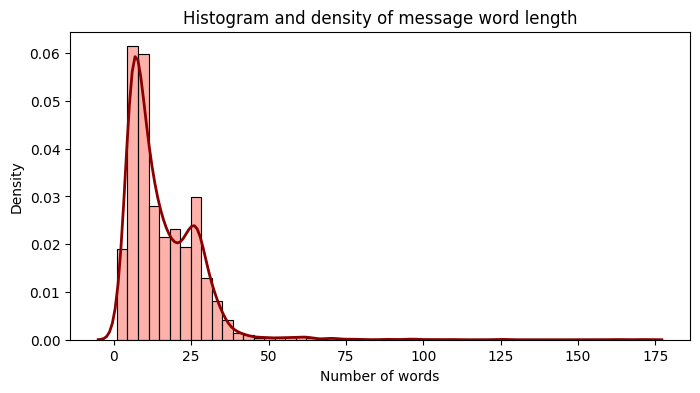

In [ ]:
plt.figure(figsize=(8,4))

# Histogram (normalized to probability density)
sns.histplot(df["word_len"], bins=50, stat="density", color="salmon", edgecolor="black", alpha=0.6)

# KDE line on top
sns.kdeplot(df["word_len"], color="darkred", linewidth=2)

plt.title("Histogram and density of message word length")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.show()

Plot histogram for character length

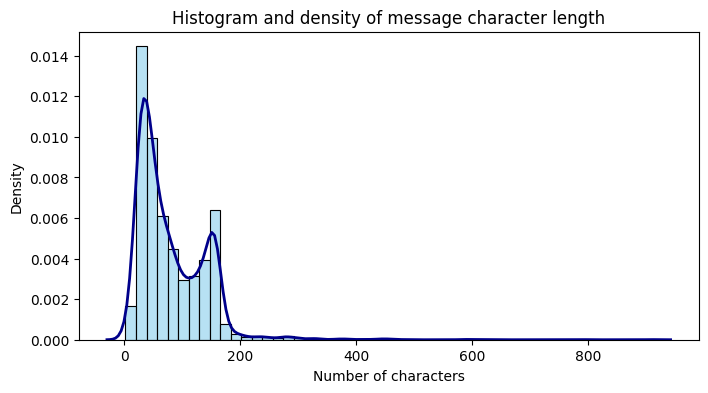

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure char_len exists
df["char_len"] = df["text"].astype(str).str.len()

plt.figure(figsize=(8,4))

# Histogram of character length, normalised
sns.histplot(df["char_len"], bins=50, stat="density",
             color="skyblue", edgecolor="black", alpha=0.6)

# Density (line) on top
sns.kdeplot(df["char_len"], color="darkblue", linewidth=2)

plt.title("Histogram and density of message character length")
plt.xlabel("Number of characters")
plt.ylabel("Density")
plt.show()

Box Plots

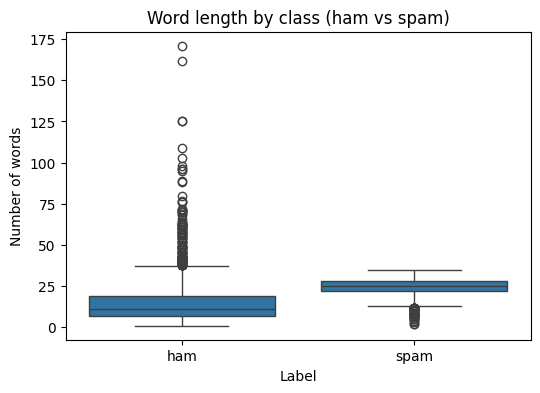

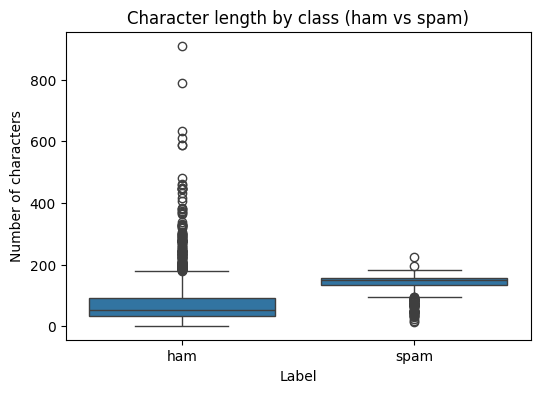

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of word length by label
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="word_len", data=df)
plt.title("Word length by class (ham vs spam)")
plt.xlabel("Label")
plt.ylabel("Number of words")
plt.show()

# Boxplot of character length by label (optional second plot)
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="char_len", data=df)
plt.title("Character length by class (ham vs spam)")
plt.xlabel("Label")
plt.ylabel("Number of characters")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = df["text"].values
y = (df["label"] == "spam").astype(int).values  # 1 = spam, 0 = ham

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [ ]:
import re
from collections import Counter

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(texts, min_freq=2, max_size=5000):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    itos = ["<PAD>", "<UNK>"]
    for word, freq in counter.most_common():
        if freq < min_freq or len(itos) >= max_size:
            break
        itos.append(word)
    stoi = {w: i for i, w in enumerate(itos)}
    return stoi, itos

stoi, itos = build_vocab(X_train)
vocab_size = len(itos)
print("Vocab size:", vocab_size)


Vocab size: 3439


In [ ]:
import numpy as np
max_len = 50

def encode(text, stoi, max_len=max_len):
    tokens = tokenize(text)
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in tokens]
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [stoi["<PAD>"]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

X_train_ids = np.stack([encode(t, stoi) for t in X_train])
X_val_ids   = np.stack([encode(t, stoi) for t in X_val])
X_test_ids  = np.stack([encode(t, stoi) for t in X_test])

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)
y_test  = y_test.astype(np.float32)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SpamDataset(X_train_ids, y_train)
val_ds   = SpamDataset(X_val_ids, y_val)
test_ds  = SpamDataset(X_test_ids, y_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn

class SpamRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        emb = self.embedding(x)          # (B, L, E)
        out, h_n = self.rnn(emb)         # h_n: (1, B, H)
        h_last = h_n.squeeze(0)          # (B, H)
        logits = self.fc(h_last)         # (B, 1)
        return logits.squeeze(1)         # (B,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpamRNN(vocab_size=vocab_size, embed_dim=64, hidden_size=64).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
from sklearn.metrics import accuracy_score

def eval_epoch(model, loader):
    model.eval()
    all_y, all_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_y.append(y_batch.cpu())
            all_pred.append(preds.cpu())
    all_y = torch.cat(all_y).numpy()
    all_pred = torch.cat(all_pred).numpy()
    return accuracy_score(all_y, all_pred)

n_epochs = 10

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_ds)
    val_acc = eval_epoch(model, val_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_acc={val_acc:.4f}")


Epoch 1: train_loss=0.4120, val_acc=0.8660
Epoch 2: train_loss=0.3952, val_acc=0.8660
Epoch 3: train_loss=0.3962, val_acc=0.8660
Epoch 4: train_loss=0.3944, val_acc=0.8660
Epoch 5: train_loss=0.3941, val_acc=0.8660
Epoch 6: train_loss=0.3942, val_acc=0.8660
Epoch 7: train_loss=0.3943, val_acc=0.8660
Epoch 8: train_loss=0.3943, val_acc=0.8660
Epoch 9: train_loss=0.3937, val_acc=0.8660
Epoch 10: train_loss=0.3940, val_acc=0.8660


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_y, all_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        all_y.append(y_batch.cpu())
        all_pred.append(preds.cpu())

all_y = torch.cat(all_y).numpy()
all_pred = torch.cat(all_pred).numpy()

print("Test classification report:")
print(classification_report(all_y, all_pred, target_names=["ham", "spam"]))
print("Confusion matrix:")
print(confusion_matrix(all_y, all_pred))


Test classification report:
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       724
        spam       0.00      0.00      0.00       112

    accuracy                           0.87       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.75      0.87      0.80       836

Confusion matrix:
[[724   0]
 [112   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
